# Liana x Tensor-cell2cell -> Using the TLS context of the VISTA project

In [3]:
#Following the in depth Python tutorial in 5 steps here : https://ccc-protocols.readthedocs.io/en/latest/index.html

# 1. Preprocessing expression data

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
import cell2cell as c2c

import liana as li
import plotnine as p9

from tqdm.auto import tqdm
from anndata import read_h5ad
import sys
import anndata

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/pkgs/miniforge3/envs/CellPhoneDB/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.


In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading

In [18]:
#Loading the example data to see how they set the context 
# Can't set several files, as they are all contactenated into one (single cell objects), not possible for my multiple objects
# Try it one by one

In [3]:
path_L1_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L1_1.h5ad"
adata_L1_1_LT = sc.read_h5ad(path_L1_1)
path_L2_2 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L2_2.h5ad"
adata_L2_2_LT = sc.read_h5ad(path_L2_2)
path_L2_2_rep = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L2_2_rep.h5ad"
adata_L2_2_rep_LT = sc.read_h5ad(path_L2_2_rep)
path_L3_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L3_1.h5ad"
adata_L3_1_LT = sc.read_h5ad(path_L3_1)
path_L4_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/xenium_objs/anndata/lung_L4_1.h5ad"
adata_L4_1_LT = sc.read_h5ad(path_L4_1)

In [7]:
adata_L1_1_LT.obs['sample'] = 'adata_L1_1_LT'
adata_L2_2_LT.obs['sample'] = 'adata_L2_2_LT'
adata_L2_2_rep_LT.obs['sample'] = 'adata_L2_2_rep_LT'
adata_L3_1_LT.obs['sample'] = 'adata_L3_1_LT'
adata_L4_1_LT.obs['sample'] = 'adata_L4_1_LT'

# Concatenate the two objects along the observation axis
combined_adata = anndata.concat([adata_L1_1_LT, adata_L2_2_LT, adata_L2_2_rep_LT, adata_L3_1_LT, adata_L4_1_LT], index_unique=None, join='outer')
adata = combined_adata
# Add the context 

In [10]:
adata_non_normalised = adata
adata_normalised = adata

In [1]:
#sc.pp.highly_variable_genes(adata_L1_1_LT, flavor = 'seurat', n_top_genes = 2000, batch_key="sample")


In [11]:
#Test to check hwo the UMAP changed by adding the preprocessing step of the vignette instead of our own before : 
# Normalize the data
sc.pp.normalize_total(adata_normalised, target_sum=1e4)
sc.pp.log1p(adata_normalised)

### 3.1.5 Dimensionality Reduction

In [24]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat', n_top_genes = 2000, batch_key="sample")

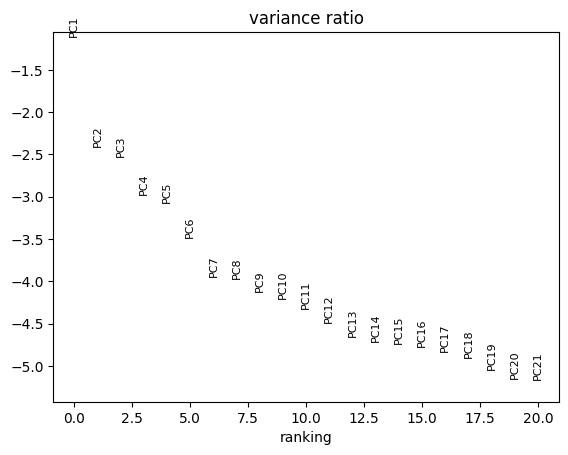

In [25]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable = True)

sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 20) # visualize PCA variance explained

# 2 Ligand-Receptor Inference

## 2.1 Environment Setup

In [3]:
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib

import scanpy as sc
import cell2cell as c2c

import liana as li
import plotnine as p9

from tqdm.auto import tqdm

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
#Take out of storage the large anndata file if it works 

In [10]:
adata

AnnData object with n_obs × n_vars = 1029521 × 288
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'sample'
    obsm: 'PCA', 'TSNE', 'UMAP'
    layers: 'logcounts'

## 2.5 Scoring Functions

### 2.5.9 Score Distributions

In [18]:
#To run Liana on only one of the samples in our large Anndata object
# pick a sample to infer the communication scores for
sample_name = 'adata_L1_1_LT'
sadata = adata[adata.obs['sample']==sample_name]
sadata

View of AnnData object with n_obs × n_vars = 72666 × 284
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'umap', 'singler_annotation_colors', 'seurat_clusters_colors', 'log1p', 'pca'
    obsm: 'PCA', 'TSNE', 'UMAP', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'logcounts'
    obsp: 'distances', 'connectivities'

In [19]:
%%time
li.method.rank_aggregate(sadata,
                           groupby='singler_annotation',
                           resource_name = 'consensus',
                           expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                           min_cells = 5,
                           n_perms = 1000,
                           use_raw = False, # run on log- and library-normalized counts
                           verbose = True,
                           inplace = True
                          )

Using `.X`!
13 features of mat are empty, they will be removed.
Using resource `consensus`.
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 72666 samples and 271 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:12<00:00, 77.49it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:47<00:00, 21.13it/s]


CPU times: user 1min 3s, sys: 144 ms, total: 1min 3s
Wall time: 1min 4s


In [23]:
liana_res = sadata.uns['liana_res'].copy()
#liana_res.to_csv(os.path.join(output_folder, sample_name + '_aggregate_scores.csv'))
# only keep those that are not liana's ranks
liana_res.head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
925,Plasma cell_IGHM,Lung_epithelia,ADAM17,MUC1,4.967675,0.0,22.936234,0.862021,1.714296,0.018867,0.868429,0.394844,0.0,0.018618,4.255585e-08
952,Plasma cell_IGHM,Tu_L1_SFTPB,ADAM17,MUC1,4.872006,0.0,22.238235,0.829657,2.231416,0.018293,0.866653,0.380979,0.0,0.017011,3.400926e-07
316,Endothelia,B cells,CD34,SELL,4.107778,0.0,16.292383,2.271369,3.700898,0.041536,0.847630,0.377026,0.0,0.000172,1.146617e-06
456,Fibroblasts tumour_B3,Lung_epithelia,ADAM17,MUC1,3.998949,0.0,10.754773,0.428122,1.281399,0.008847,0.818832,0.178268,0.0,0.065982,3.076496e-05
196,DC_2,T_regs,CD86,CTLA4,3.925214,0.0,13.235380,3.161279,4.350503,0.055950,0.833720,0.170189,0.0,0.000011,4.215731e-05


In [41]:
# convert to long format by index, and each score and value in different columns
liana_res = liana_res.loc[:, liana_res.columns[~liana_res.columns.str.contains(pat = 'rank')]]
liana_res = liana_res.melt(id_vars=['source', 'target', 'ligand_complex', 'receptor_complex'], var_name='score', value_name='value')

liana_res['score'] = liana_res['score'].astype('category')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


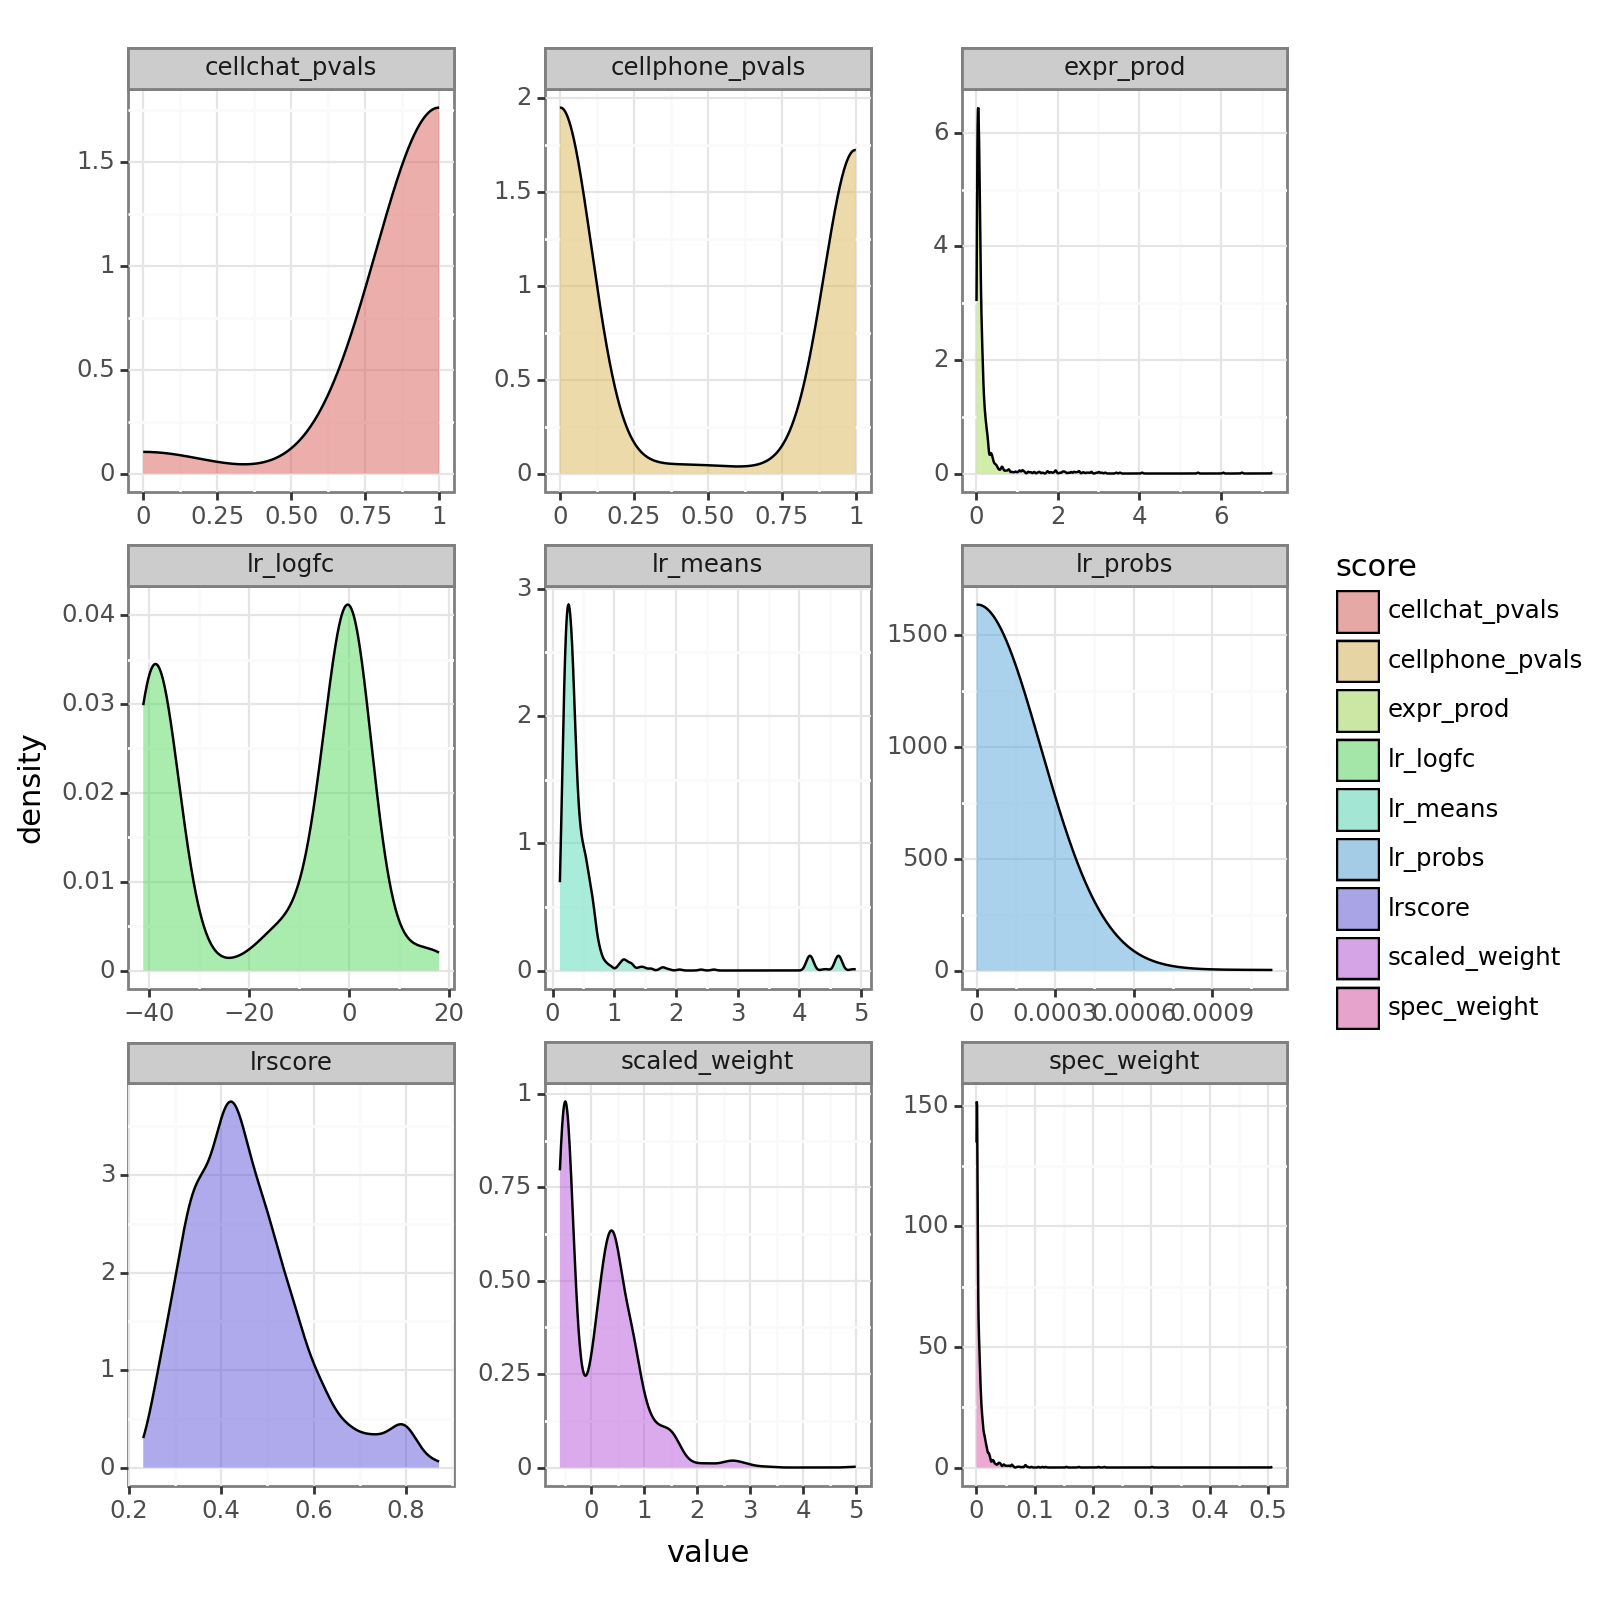

<Figure Size: (800 x 800)>

In [42]:
(p9.ggplot(liana_res, p9.aes(x='value', fill='score')) +
 p9.geom_density(alpha=0.5) +
 p9.facet_wrap('~score', scales='free') +
 p9.theme_bw() +
 p9.theme(figure_size=(8, 8))
 )

In [105]:
#Checking the correlation between different Specificity scores : Here in order those of CellPhoneDB, NATMI, CellChat, Connectome, log2FC, specificity_rank, Geometric Mean	

In [24]:
specificity_scores = ['cellphone_pvals', 'spec_weight', 'cellchat_pvals', 'scaled_weight', 'lr_logfc', 'specificity_rank']
liana_corr = sadata.uns['liana_res'].copy()[specificity_scores].corr(method = 'spearman')

In [29]:
liana_corr

,cellphone_pvals,spec_weight,cellchat_pvals,scaled_weight,lr_logfc,specificity_rank
cellphone_pvals,1.000000,-0.826159,0.184438,-0.884709,-0.881040,0.768674
spec_weight,-0.826159,1.000000,-0.339879,0.923826,0.911099,-0.853554
cellchat_pvals,0.184438,-0.339879,1.000000,-0.266667,-0.252754,0.379932
scaled_weight,-0.884709,0.923826,-0.266667,1.000000,0.961800,-0.875570
lr_logfc,-0.881040,0.911099,-0.252754,0.961800,1.000000,-0.874287
specificity_rank,0.768674,-0.853554,0.379932,-0.875570,-0.874287,1.000000


In [97]:
df_=sadata.uns['liana_res'][specificity_scores].copy()
D=c2c.clustering.compute_distance(df_.T,metric='correlation')
D=pd.DataFrame(D,index=df_.T.index,columns=df_.T.index)

In [108]:
#test for magnitude scores
magnitude_scores = ['lr_means', 'expr_prod', 'lrscore', 'lr_probs', 'expr_prod']
liana_corr = sadata.uns['liana_res'].copy()[magnitude_scores].corr(method = 'spearman')

Interaction space detected as a distance matrix


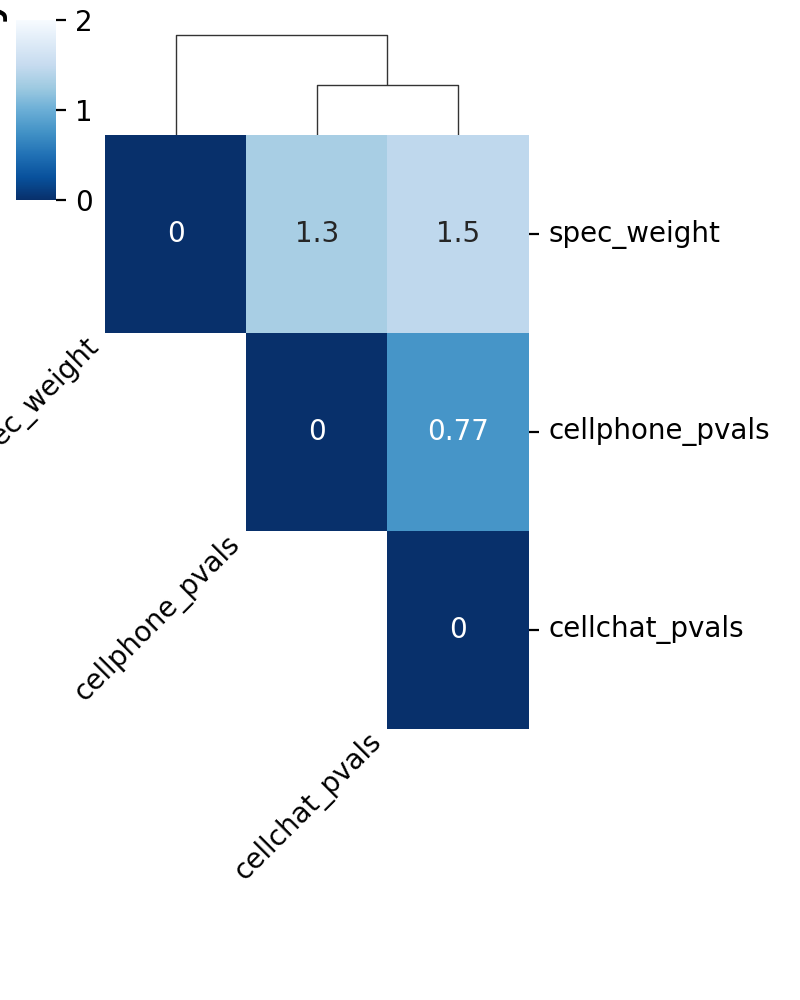

In [99]:
cm = c2c.plotting.clustermap_cci(D,
                                 method='ward',
                                 optimal_leaf=True,
                                 metadata=None,
                                 title='',
                                 cbar_title='Similarity',
                                 cmap='Blues_r',
                                 vmax=2.,
#                                  vmin=0.,
                                 annot=True,
                                 dendrogram_ratio=0.15,
                                figsize=(4,5))

##### 2.5.9 a) Score Distributions Adapting the matrices for p values 

Using sdata that only has one of the samples treated.
- make sure the p values seam reasonible -> Print out the plots with inferior p values for significance (done in the next b))
- invert them
- then re-run the correlation matrix
- then follows ChatG’s code for printing the heat map.


In [91]:
#inverting the p vals and saving them in the column
sadata.uns['liana_res']['cellchat_pvals_inverted'] = 1 / (sadata.uns['liana_res']['cellchat_pvals'] + 0.00000001)
sadata.uns['liana_res']['cellphone_pvals_inverted'] = 1 / (sadata.uns['liana_res']['cellphone_pvals'] + 0.00000001)
sadata.uns['liana_res']['specificity_rank_inverted'] = 1 / (sadata.uns['liana_res']['specificity_rank'] - 0.00000000001)
sadata.uns['liana_res']

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank,cellchat_pvals_inverted,cellphone_pvals_inverted,magnitude_rank_inverted,specificity_rank_inverted
925,Plasma cell_IGHM,Lung_epithelia,ADAM17,MUC1,4.967675,0.0,22.936234,0.862021,1.714296,0.018867,0.868429,0.394844,0.0,0.018618,4.255585e-08,100000000.0,100000000.0,2.349854e+07,53.711486
952,Plasma cell_IGHM,Tu_L1_SFTPB,ADAM17,MUC1,4.872006,0.0,22.238235,0.829657,2.231416,0.018293,0.866653,0.380979,0.0,0.017011,3.400926e-07,100000000.0,100000000.0,2.940376e+06,58.785813
316,Endothelia,B cells,CD34,SELL,4.107778,0.0,16.292383,2.271369,3.700898,0.041536,0.847630,0.377026,0.0,0.000172,1.146617e-06,100000000.0,100000000.0,8.721310e+05,5824.172935
456,Fibroblasts tumour_B3,Lung_epithelia,ADAM17,MUC1,3.998949,0.0,10.754773,0.428122,1.281399,0.008847,0.818832,0.178268,0.0,0.065982,3.076496e-05,100000000.0,100000000.0,3.250451e+04,15.155722
196,DC_2,T_regs,CD86,CTLA4,3.925214,0.0,13.235380,3.161279,4.350503,0.055950,0.833720,0.170189,0.0,0.000011,4.215731e-05,100000000.0,100000000.0,2.372068e+04,91902.979940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,T_CD4,Fibroblasts,FASLG,FAS,1.043718,0.0,0.887039,0.578422,2.103466,0.008490,0.564845,0.000000,1.0,0.210440,1.000000e+00,1.0,100000000.0,1.000000e+00,4.751954
1073,T_CD4,Fibroblasts tumour_B3,ADAM17,MUC1,1.070444,1.0,1.130000,-0.603956,-1.146843,0.000930,0.594329,0.000000,1.0,1.000000,1.000000e+00,1.0,1.0,1.000000e+00,1.000000
1074,T_CD4,Fibroblasts tumour_B3,FASLG,FAS,0.958947,0.0,0.786343,0.531844,2.155182,0.007526,0.549982,0.000000,1.0,0.210440,1.000000e+00,1.0,100000000.0,1.000000e+00,4.751954
1264,T_regs,Plasma cell_IGKC,CD86,CD28,0.881741,0.0,0.713117,0.491235,1.719162,0.003051,0.537859,0.000000,1.0,0.997528,1.000000e+00,1.0,100000000.0,1.000000e+00,1.002478


In [92]:
# Re run the correlation matrix
specificity_scores = ['cellphone_pvals_inverted', 'spec_weight', 'cellchat_pvals_inverted', 'scaled_weight', 'lr_logfc', 'specificity_rank_inverted']
liana_corr = sadata.uns['liana_res'].copy()[specificity_scores].corr(method = 'spearman')
liana_corr

,cellphone_pvals_inverted,spec_weight,cellchat_pvals_inverted,scaled_weight,lr_logfc,specificity_rank_inverted
cellphone_pvals_inverted,1.000000,0.826159,0.184438,0.884709,0.881040,0.768674
spec_weight,0.826159,1.000000,0.339879,0.923826,0.911099,0.853554
cellchat_pvals_inverted,0.184438,0.339879,1.000000,0.266667,0.252754,0.379932
scaled_weight,0.884709,0.923826,0.266667,1.000000,0.961800,0.875570
lr_logfc,0.881040,0.911099,0.252754,0.961800,1.000000,0.874287
specificity_rank_inverted,0.768674,0.853554,0.379932,0.875570,0.874287,1.000000


In [ ]:
#Run with the Heat Map -> 

##### 2.5.9  b) Checking out p values that are too weak

In [61]:
font = matplotlib.font_manager.FontProperties(weight='bold', size=7)
for ax in [cm.ax_heatmap, cm.ax_cbar]:
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(font)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(font)

    text = ax.yaxis.label
    text.set_font_properties(font)

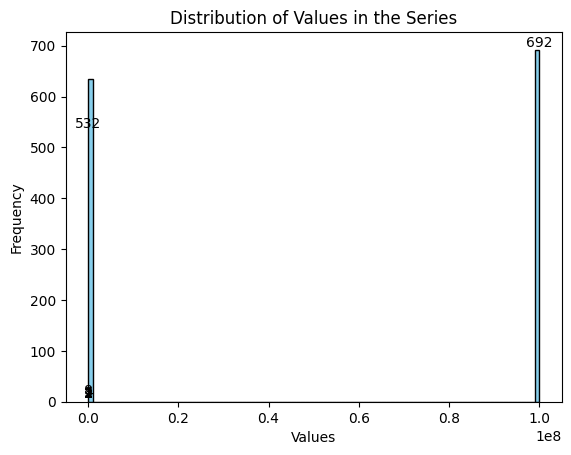

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Create series -> Select ony by one the different specificity scores. s
data = sadata.uns['liana_res']['cellphone_pvals_inverted']

# Plot histogram
plt.hist(data, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values in the Series')

# Add frequency labels atop each bin
for i, freq in enumerate(data.value_counts()):
    plt.text(data.value_counts().index[i], freq, str(freq), ha='center', va='bottom')

plt.show()


In [ ]:
#Give a total sum of the values in the previous matrix : 

### 2.5.11 Single-Sample Dotplot

In [1]:
#Need to chose some genes and cells of interest -> Daria VISTA. 


li.pl.dotplot(
    adata=sadata,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=["B", "pDC", "Macrophages"],
    target_labels=["T", "Mast", "pDC", "NK"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

IndentationError: unexpected indent (264680105.py, line 5)

#### Liana for RCTD

In [7]:
#Get Rctd annotation
path_chuvio_L1_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/data/rcd_annot/chuvio_L1_1_RCTD_lvl3.h5ad"
chuvio_L1_1 = sc.read_h5ad(path_chuvio_L1_1)
path_chuvio_L1_2 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/data/rcd_annot/chuvio_L1_2_RCTD_lvl3.h5ad"
chuvio_L1_2 = sc.read_h5ad(path_chuvio_L1_2)
path_chuvio_L2_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/data/rcd_annot/chuvio_L2_1_RCTD_lvl3.h5ad"
chuvio_L2_1 = sc.read_h5ad(path_chuvio_L2_1)
path_chuvio_L3_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/data/rcd_annot/chuvio_L3_1_RCTD_lvl3.h5ad"
chuvio_L3_1 = sc.read_h5ad(path_chuvio_L3_1)
path_chuvio_L4_1 = "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/astear/data/rcd_annot/chuvio_L4_1_RCTD_lvl3.h5ad"
chuvio_L4_1 = sc.read_h5ad(path_chuvio_L4_1)

In [8]:
chuvio_L1_1

AnnData object with n_obs × n_vars = 71187 × 313
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'libsize_drop', 'sizeFactor', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'singler_annotation', 'ident', 'RCTD_lvl3'
    uns: 'X_name'
    obsm: 'PCA', 'TSNE', 'UMAP'
    layers: 'logcounts'

In [25]:
#run Liana
li.method.rank_aggregate(chuvio_L4_1,
                           groupby='RCTD_lvl3',
                           resource_name = 'consensus',
                           expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                           min_cells = 5,
                           n_perms = 100,
                           use_raw = False, # run on log- and library-normalized counts
                           verbose = True,
                           inplace = True
                          )

Using `.X`!
Converting to sparse csr matrix!
Make sure that normalized counts are passed!
Using resource `consensus`.
0.91 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 829907 samples and 313 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB



100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat



100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


In [26]:
#Save the results
chuvio_L4_1_liana = chuvio_L4_1.uns['liana_res'].copy()

In [27]:
chuvio_L4_1_liana.to_csv('chuvio_L4_1_liana.csv', index=False)

In [32]:
len(chuvio_L4_1_liana)

14254

In [35]:
filtered_df = chuvio_L4_1_liana[chuvio_L4_1_liana['magnitude_rank'] <= 0.05]

In [36]:
len(filtered_df)

808

In [37]:
filtered_df

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
4577,Endothelia_vascular,Tu_L4,VIM,CD44,7.289407,0.0,46.333630,0.990546,NaN,0.009472,0.935759,0.000354,0.0,NaN,4.419305e-11
5776,Fibroblast,Tu_L4,COL1A1,CD44,7.509574,0.0,48.395004,0.804539,NaN,0.013081,0.937055,0.000332,0.0,NaN,1.377190e-10
5779,Fibroblast,Tu_L4,FN1,CD44,6.764970,0.0,41.423454,0.720179,NaN,0.010356,0.932309,0.000279,0.0,NaN,4.647661e-10
4269,Endothelia_vascular,Macrophage,VIM,CD44,6.347707,0.0,27.692808,0.734481,NaN,0.005661,0.918442,0.000227,0.0,NaN,1.514865e-08
4217,Endothelia_vascular,Epi_lung,VIM,CD44,6.332984,0.0,27.401361,0.730453,NaN,0.005601,0.918045,0.000227,0.0,NaN,1.863119e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10887,TNK_dividing,T_CXCL13,FN1,CD44,3.731761,0.0,10.879235,0.078809,-inf,0.002720,0.875905,0.000038,0.0,NaN,9.331164e-03
12696,T_CTL,Tu_L4,TIMP2,CD44,2.868439,0.0,4.941201,0.189031,-inf,0.002727,0.826294,0.000043,0.0,NaN,9.478570e-03
10230,Pericyte,T_CTL,TIMP2,CD44,2.493155,0.0,6.168816,0.172353,-inf,0.003404,0.841647,0.000055,0.0,NaN,9.524038e-03
2887,DC_activated,B_plasma,VIM,CD44,2.673899,1.0,4.924690,-0.090352,-inf,0.001007,0.826054,0.000043,0.0,NaN,9.638328e-03


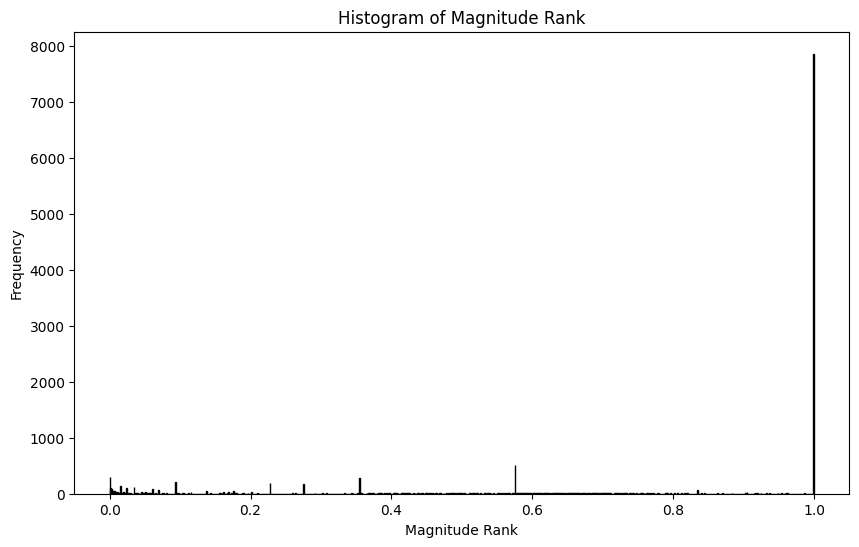

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(chuvio_L4_1_liana['magnitude_rank'], bins=1000, edgecolor='black')
plt.xlabel('Magnitude Rank')
plt.ylabel('Frequency')
plt.title('Histogram of Magnitude Rank')
plt.show()

## 2.6 Run LIANA by Sample

In [13]:
#%%time
li.mt.rank_aggregate.by_sample(adata,
                              sample_key='sample',
                              groupby='singler_annotation',
                              resource_name = 'consensus',
                              expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                              min_cells = 5,
                              n_perms = 100,
                              use_raw = False, # run on log- and library-normalized counts
                              verbose = True,
                              inplace = True
                              )

Converting `sample` to categorical!
Now running: adata_L4_1_LT: 100%|██████████| 5/5 [01:22<00:00, 16.52s/it]    


In [30]:
#saved resulting object
#adata_non_normalised_5Lsamples = adata_non_normalised
#adata_non_normalised_5Lsamples.write_h5ad("adata_non_normalised_5Lsamples.h5ad")

In [8]:
adata = read_h5ad("adata_non_normalised_5Lsamples.h5ad")

In [15]:
adata.uns['liana_res']['sample']

0       adata_L1_1_LT
1       adata_L1_1_LT
2       adata_L1_1_LT
3       adata_L1_1_LT
4       adata_L1_1_LT
            ...      
4620    adata_L4_1_LT
4621    adata_L4_1_LT
4622    adata_L4_1_LT
4623    adata_L4_1_LT
4624    adata_L4_1_LT
Name: sample, Length: 4625, dtype: object

### OUT : Looking at the ratio of significant interactions to total cells found for each sample

In [33]:
%store -r datasets

In [50]:
for index, element in enumerate(datasets) : 
    print(f" {datasets[index].obs['sample'][0]} : {len(element)}")

 adata_L1_1_LT : 72666
 adata_L2_2_LT : 49226
 adata_L2_2_rep_LT : 52281
 adata_L3_1_LT : 186942
 adata_L4_1_LT : 668406


In [61]:
dataset_info = {}

dataset_info["adata_L1_1_LT"] = [1326, 72666]
dataset_info["adata_L2_2_LT"] = [593, 49226]
dataset_info["adata_L2_2_rep_LT"] = [635, 52281]
dataset_info["adata_L3_1_LT"] = [1624, 186942]
dataset_info["adata_L4_1_LT"] = [447, 668406]

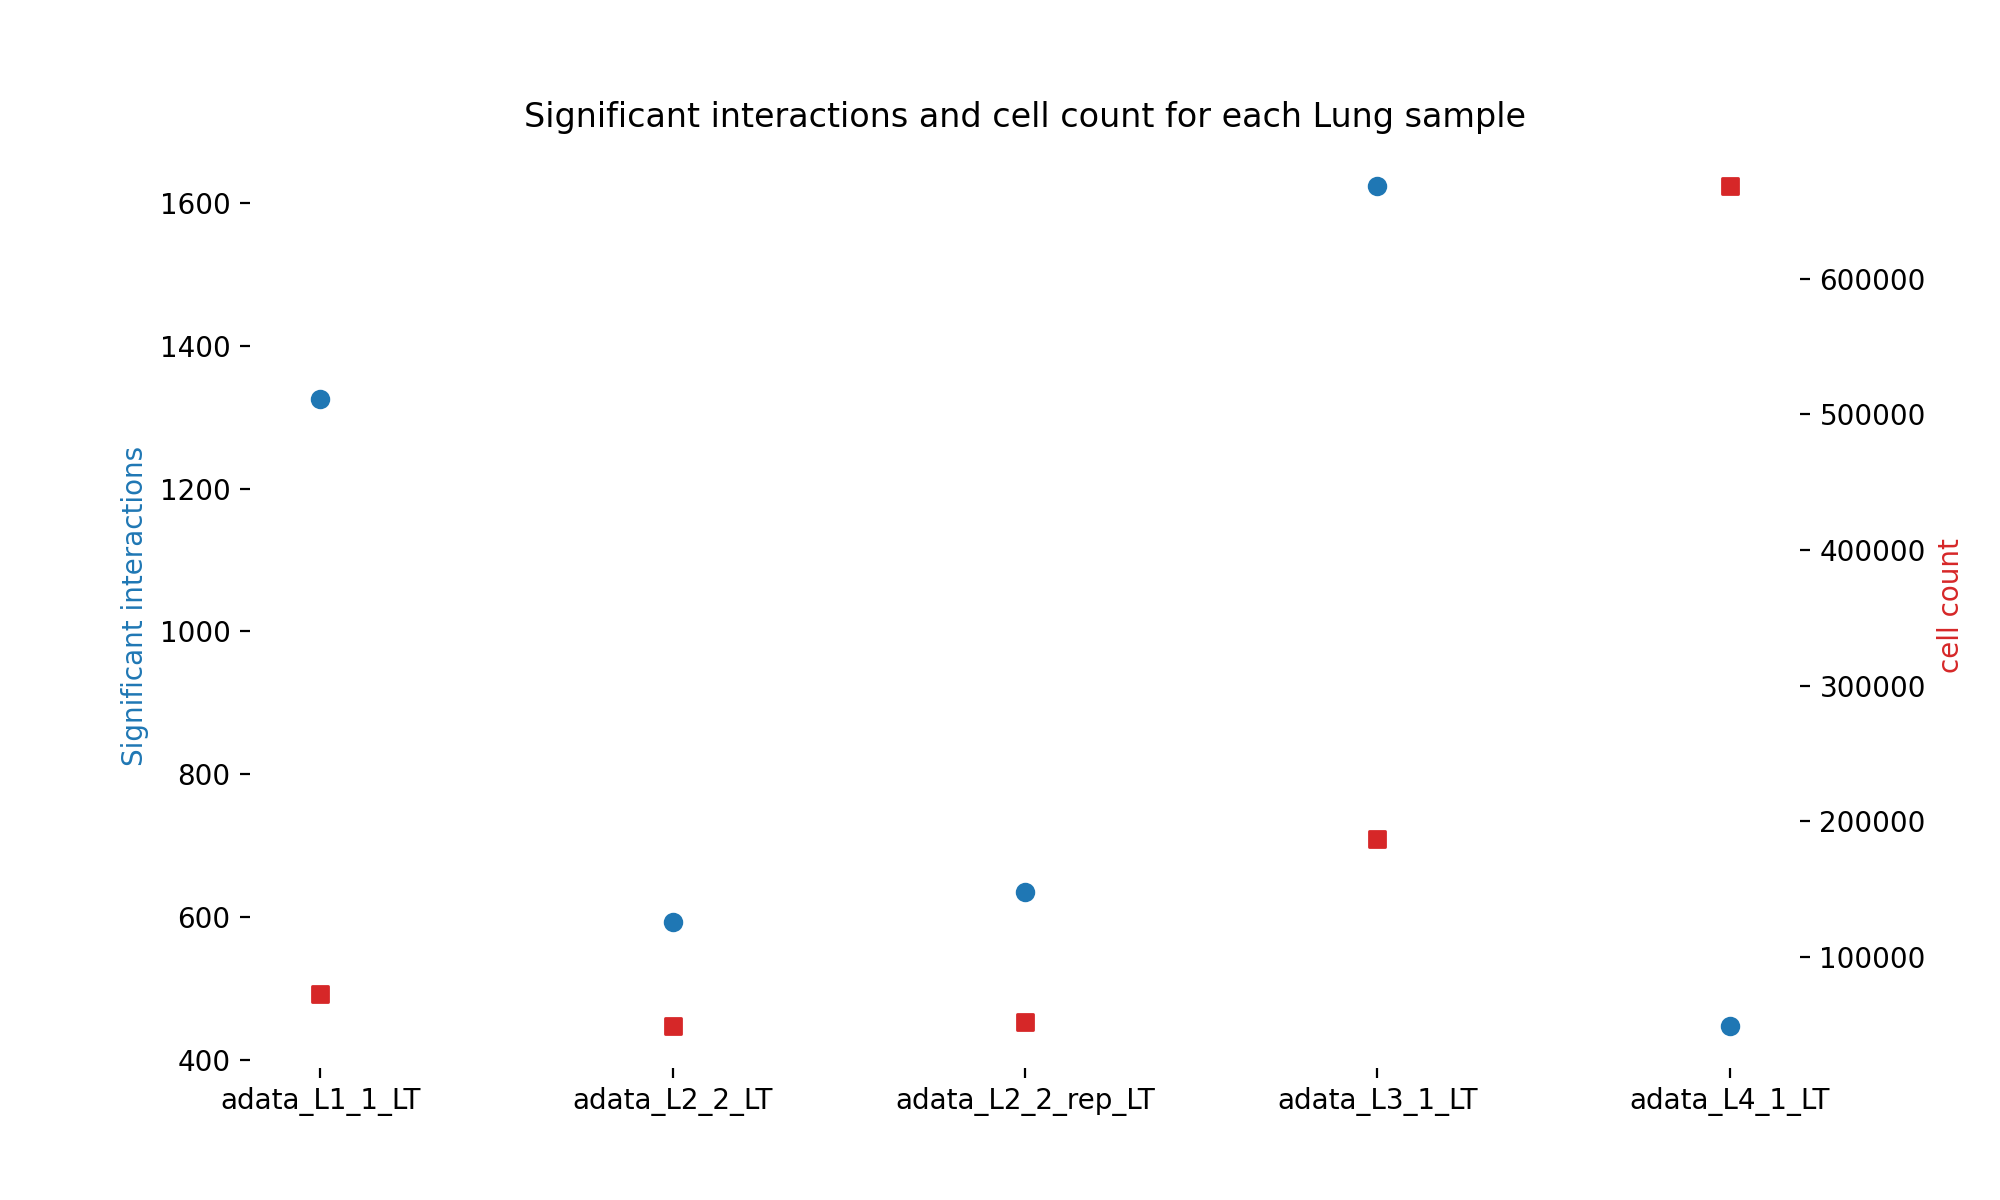

In [73]:
# Extract first and second values from each dictionary value
x_values = list(dataset_info.keys())
first_values = [value[0] for value in dataset_info.values()]
second_values = [value[1] for value in dataset_info.values()]

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot first set of values with left axis
ax1.scatter(x_values, first_values, color='tab:blue', marker='o', label='First Values')
ax1.set_ylabel('Significant interactions', color='tab:blue')

# Create secondary y-axis and plot second set of values
ax2 = ax1.twinx()
ax2.scatter(x_values, second_values, color='tab:red', marker='s', label='Second Values')
ax2.set_ylabel('cell count', color='tab:red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2

# Set x-axis tick labels vertically
plt.xticks(rotation=90)

# Title
plt.title('Significant interactions and cell count for each Lung sample')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.show()


In [80]:
import anndata

# Assuming your AnnData object is named 'adata'
# adata = ...

# Filter rows based on condition
condition = adata.obs['sample'] == "adata_L1_1_LT"
filtered_adata = adata[condition, :]

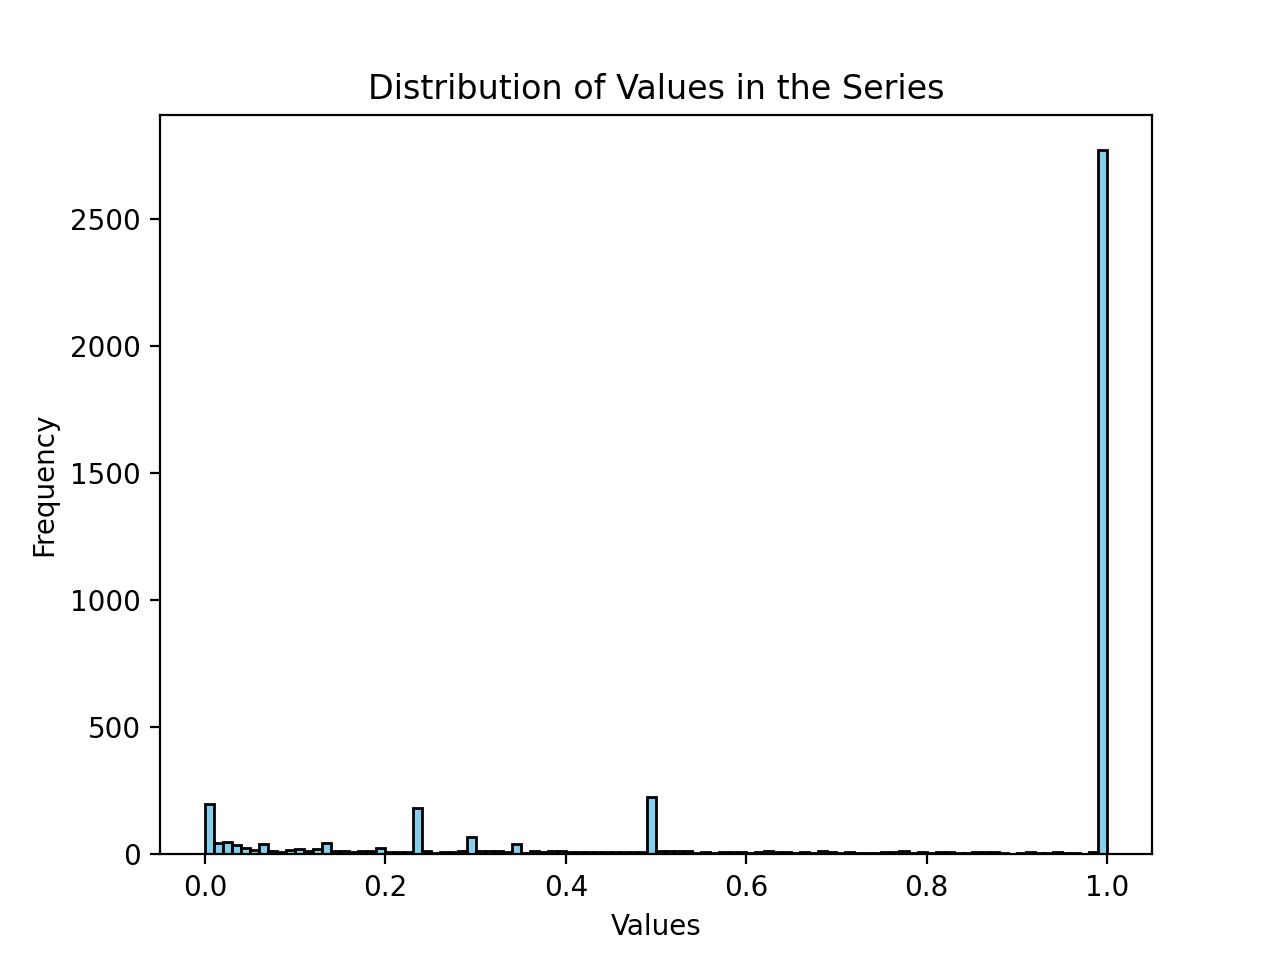

In [20]:
#checking out the specificity ranks that we get for each sample

data = adata.uns['liana_res']['specificity_rank']

# Plot histogram
plt.hist(data, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Values in the Series')

plt.show()


In [ ]:
#How does the specificity change depending on the sample ? 
#Make a hist plot for each of the samples of specificity scores ? 
adata.uns['liana_res'][["sample"] = ""]
adata.uns['liana_res']['specificity_rank']

In [38]:
adata.uns['liana_res']['source'].unique()

array(['Plasma cell_IGHM', 'Endothelia', 'Fibroblasts tumour_B3', 'DC_2',
       'Tu_L1_SFTPB', 'Monocytes', 'B cells', 'Macrophages', 'Pericytes',
       'Fibroblasts', 'Lung_epithelia', 'Endothelia_lymphatic',
       'Smooth_muscle', 'T_regs', 'T_CD4', 'T_CTL', 'Plasma cell_IGKC',
       'Plasma cell_IGHG3', 'DC_plasmacytoid', 'DC_1', 'DC_activated',
       'NK', 'Plasma cell_IGHA1', 'Mast cells', 'Tu_L2_FXYD2',
       'Plasma cell_IGHG1', 'Granulocytes', 'Proliferating_TNK',
       'Plasma cell_IGLC1', 'T_CD8_exhausted', 'T_CXCL13',
       'Tu_L2_G0S2_immune_signature', 'Tu_L3_G0S2',
       'Tu_L4_KRT17_neutrophil_signature'], dtype=object)

In [ ]:
pe

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


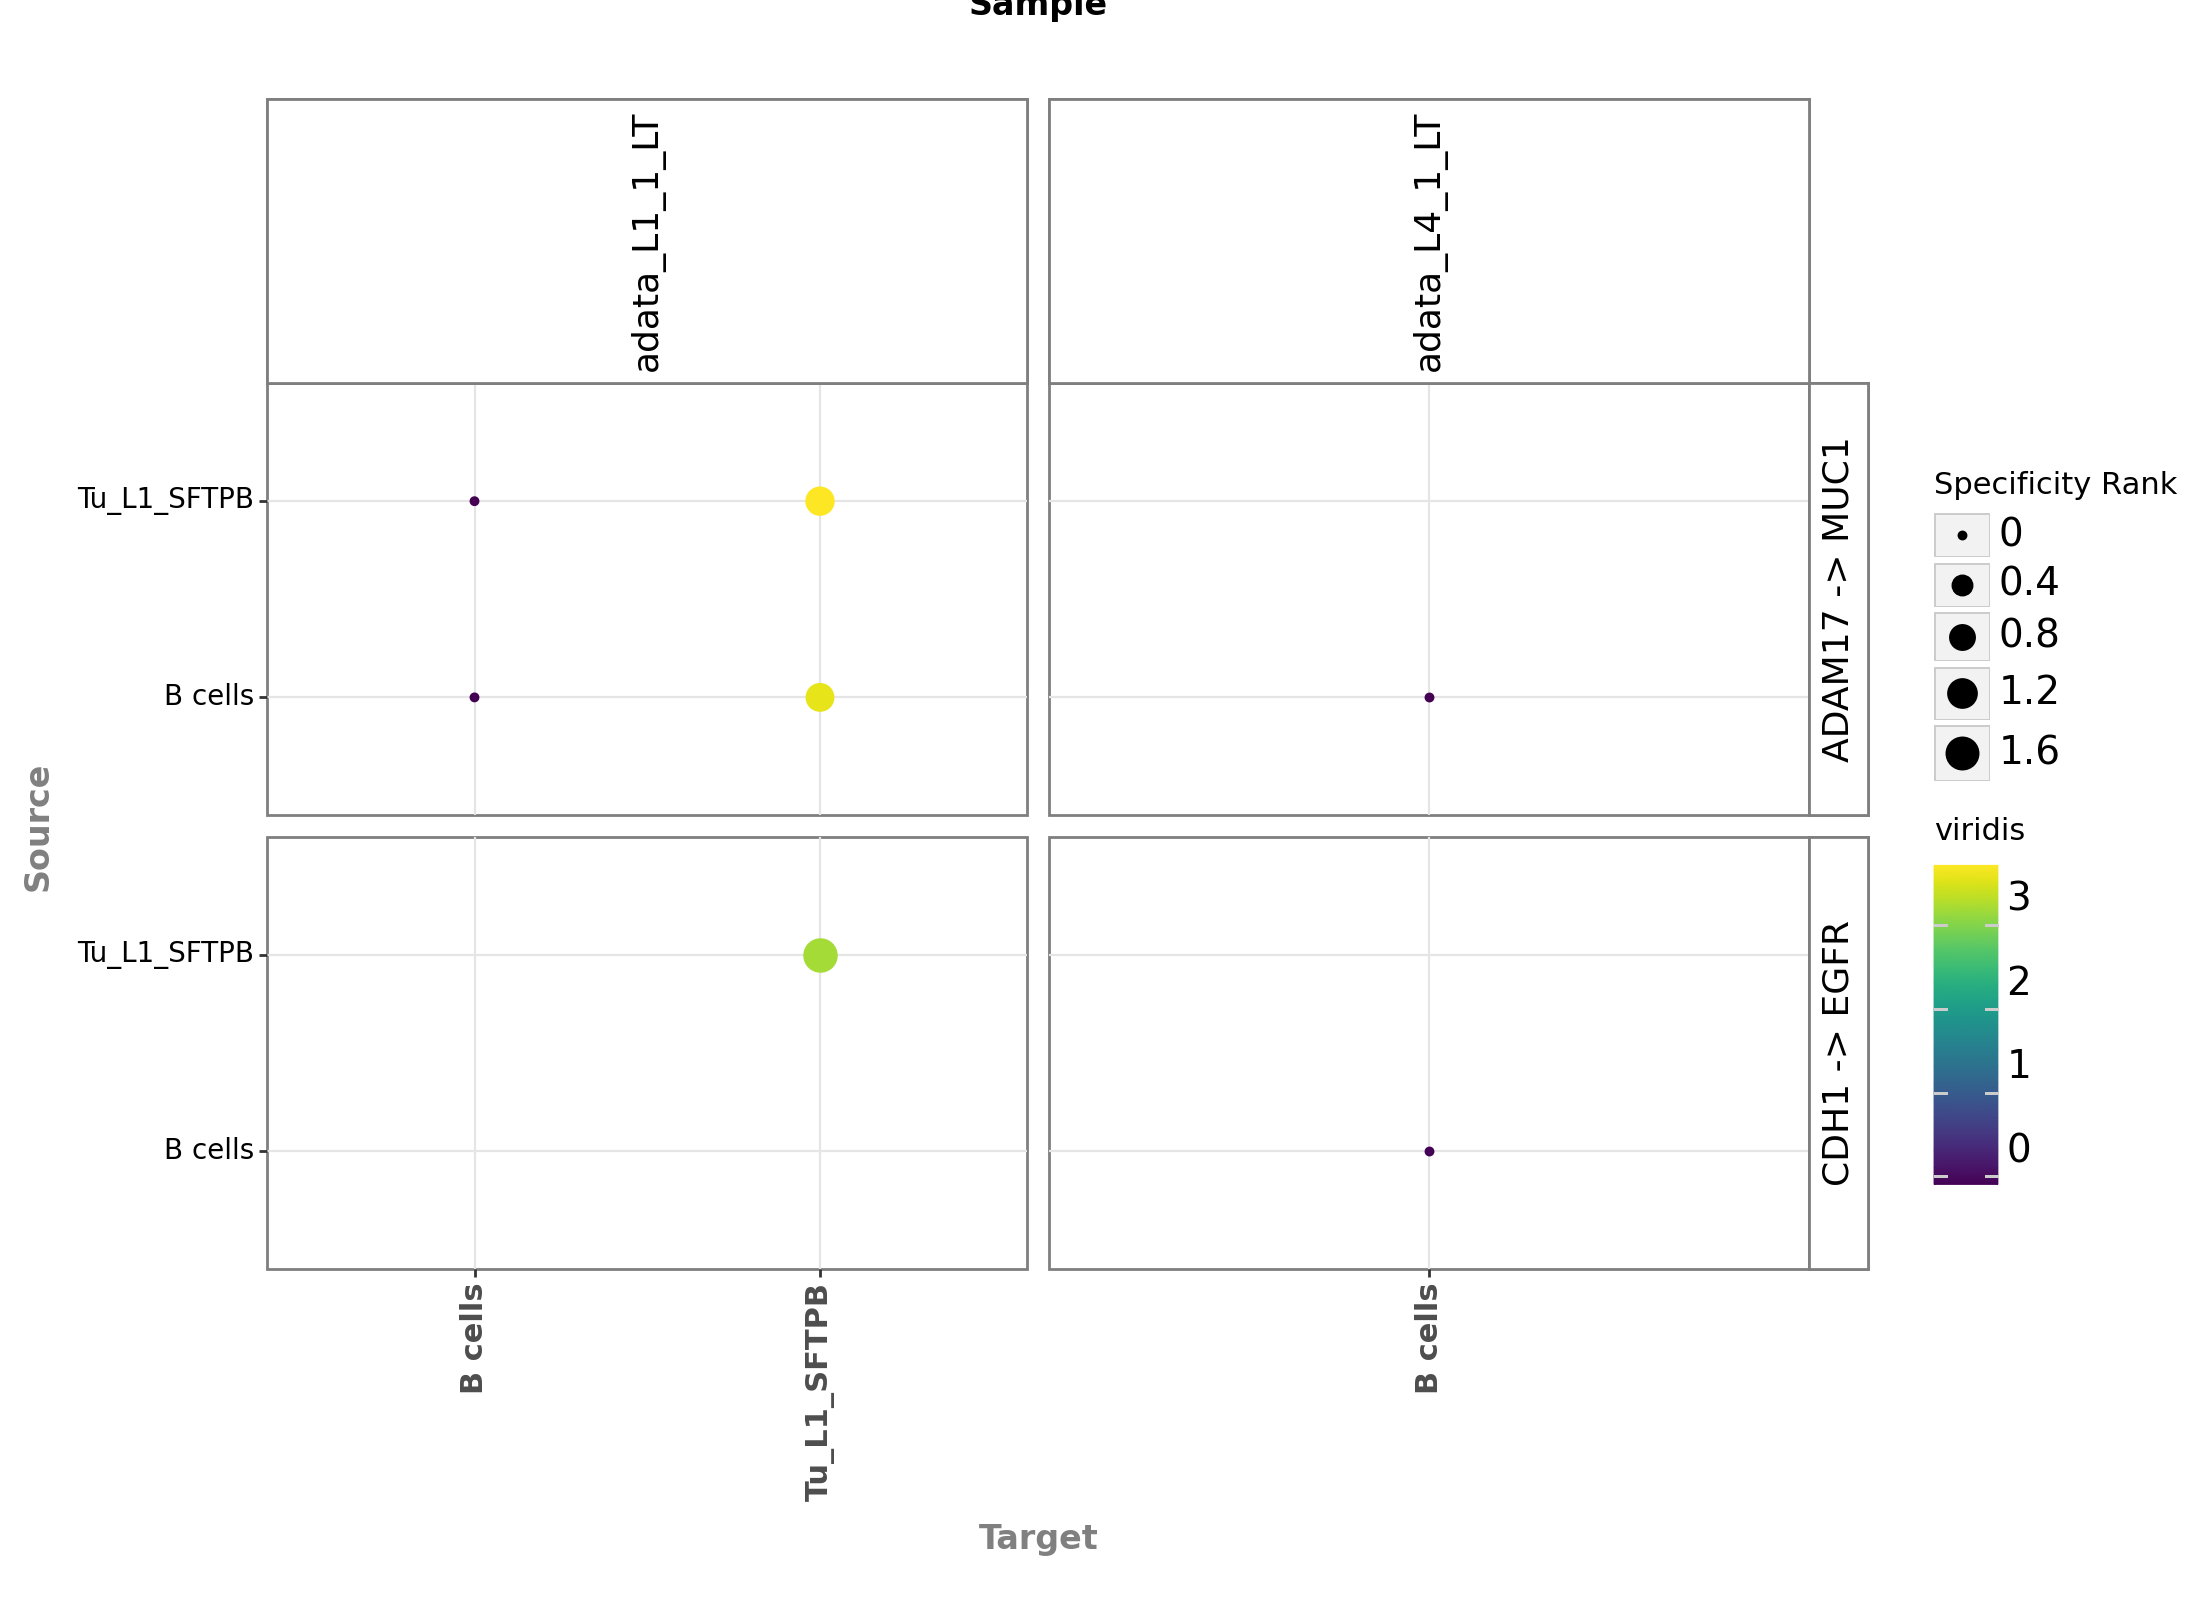

<Figure Size: (1100 x 800)>

In [16]:
plot = (li.pl.dotplot_by_sample(adata=adata,
                               colour='magnitude_rank',
                               size='specificity_rank',
                               source_labels=["Tu_L1_SFTPB", "B cells"],
                               target_labels=["B cells", "Tu_L1_SFTPB"],
                               ligand_complex = ['ADAM17', 'CDH1'],
                               receptor_complex= ['MUC1', 'EGFR'],
                               sample_key='sample',
                               inverse_colour=True,
                               inverse_size=True,
                               figure_size=(11, 8),
                               size_range=(1, 6),
                               ) +
         p9.labs(color='Magnitude rank', size='Specificity Rank'))

#plot.save(output_folder + '/Dotplot-by-sample.pdf', height=8, width=11)
plot

### 2.6 a) Dot plot for total sig interactions ? 

In [ ]:
plot = (li.pl.dotplot_by_sample(adata=adata,
                               colour='magnitude_rank',
                               size='specificity_rank',
                               source_labels=["B", "pDC", "Epithelial"],
                               target_labels=["Macrophages", "Mast", "pDC", "NK"],
                               ligand_complex = ['VIM', 'SCGB3A1'],
                               receptor_complex= ['CD44', 'MARCO'],
                               sample_key='sample',
                               inverse_colour=True,
                               inverse_size=True,
                               figure_size=(11, 8),
                               size_range=(1, 6),
                               ) +
         p9.labs(color='Magnitude rank', size='Specificity Rank'))

#plot.save(output_folder + '/Dotplot-by-sample.pdf', height=8, width=11)
plot

### 2.6 b) Dot plot for mag max sig interactions ? 

### 2.6 c) Dot plot for signif max sig interactions ? 

## 2.7 Supplementary information about LIANA

## 2.6-OUT : Run LIANA by Sample WITH neutro datasets of Daria

In [46]:
neutro_annotations = pd.read_csv("/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium/results/celltype_annotation/singler_db/neutrophils_l3.csv")
#neutro_annotations.set_index(neutro_annotations.columns[0], inplace=True)

In [44]:
neutro_annotations["neutro_annot"].unique()

array(['Tu_L4', 'Neutrophil', 'Fibroblast', 'Muscle_smooth',
       'Neutrophil_VISR_pos', 'Pericyte', 'DC_2', 'Endothelia_vascular',
       'T_reg', 'DC_pc', 'T_CTL', 'T_CD4', 'T_CD8_exhausted', 'B_plasma',
       'DC_1', 'Macrophage', 'Monocyte', 'Mast_cell', 'Epi_lung',
       'B_cell', 'DC_activated', 'T_CXCL13', 'Granulocyte', 'NK',
       'TNK_dividing', 'no_assigned_label'], dtype=object)

In [21]:
neutro_annotations

NameError: name 'neutro_annotations' is not defined

# 3. Generating a 4D-Communication Tensor from computed communication scores

## 3.1 Inital Setup

In [17]:
data_folder = '../../Analysis/TensorC2C/data/liana-outputs/'
output_folder = '../../Analysis/TensorC2C/data/tc2c-outputs/'
c2c.io.directories.create_directory(output_folder)

../../Analysis/TensorC2C/data/tc2c-outputs/ already exists.


In [18]:
#adata = read_h5ad("adata_non_normalised_5Lsamples.h5ad")
liana_res = adata.uns['liana_res']

In [19]:
adata.obs

,orig.ident,nCount_originalexp,nFeature_originalexp,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,...,total,libsize_drop,sizeFactor,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,singler_annotation,ident,sample
L1_1_aaaajpka-1,L1,330.0,58,L1_1_aaaajpka-1,1270.714355,2549.835205,330,0,0,0,...,330.0,False,3.078942,86.0,30,0,0,Tu_L1_SFTPB,0,adata_L1_1_LT
L1_1_aaaalfpg-1,L1,459.0,62,L1_1_aaaalfpg-1,1273.005737,2539.648682,459,0,0,0,...,459.0,False,4.282529,87.0,33,2,2,Tu_L1_SFTPB,2,adata_L1_1_LT
L1_1_aaabioof-1,L1,244.0,49,L1_1_aaabioof-1,1281.513184,2559.730957,245,0,0,0,...,245.0,False,2.276551,87.0,30,0,0,Tu_L1_SFTPB,0,adata_L1_1_LT
L1_1_aaafigff-1,L1,560.0,62,L1_1_aaafigff-1,1282.873901,2531.250488,560,0,0,0,...,560.0,False,5.224871,81.0,29,2,2,Tu_L1_SFTPB,2,adata_L1_1_LT
L1_1_aaagflfb-1,L1,162.0,40,L1_1_aaagflfb-1,1287.822388,2548.740723,162,0,0,0,...,162.0,False,1.511481,93.0,37,0,0,Tu_L1_SFTPB,0,adata_L1_1_LT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L4_1_oikofajc-1,L4,10.0,10,L4_1_oikofajc-1,8325.805664,5955.173340,10,0,0,0,...,10.0,False,0.121889,26.0,10,34,34,DC_1,34,adata_L4_1_LT
L4_1_oikofnef-1,L4,19.0,17,L4_1_oikofnef-1,8298.780273,5956.855957,19,0,0,0,...,19.0,False,0.231590,36.0,17,26,26,Tu_L4_KRT17_neutrophil_signature,26,adata_L4_1_LT
L4_1_oikoghdp-1,L4,13.0,10,L4_1_oikoghdp-1,8301.811523,5962.847656,13,0,0,0,...,13.0,False,0.158456,30.0,10,23,23,DC_1,23,adata_L4_1_LT
L4_1_oikohdno-1,L4,10.0,10,L4_1_oikohdno-1,8309.046875,5964.718262,10,0,0,0,...,10.0,False,0.121889,26.0,10,18,18,DC_1,18,adata_L4_1_LT


## 3.2 Create 4D-Communication Tensor

Specifying the context. In the original they have 12 samples and the first letter tells them if it is Control or sick, so the following ordering operation allows it to setup the order of samples depending on the context. We jsut want to see the dfference between L4 that has two LSE and the others. 

In [20]:
sorted_samples = sorted(liana_res['sample'].unique())

## 3.3 Generate tensor

To generate the 4D-communication tensor, we will to create matrices with the communication scores for each of the ligand-receptor pairs within the same sample, then generate a 3D tensor for each sample, and finally concatenate them to form the 4D tensor.

Briefly, we use the LIANA dataframe and communication scores to organize them as follows:
-> If you used a pipeline that generated negative scores, replace these with 0,  Otherwise, by default, Tensor-cell2cell will treat these as NaN.
-> ...

In [22]:
#Here we use the magnitude score but we could use the specificity score, in score_key. Also try lowering the outer_fraction value for rare occurences
tensor = li.multi.to_tensor_c2c(liana_res=liana_res, # LIANA's dataframe containing results
                                sample_key='sample', # Column name of the samples
                                source_key='source', # Column name of the sender cells
                                target_key='target', # Column name of the receiver cells
                                ligand_key='ligand_complex', # Column name of the ligands
                                receptor_key='receptor_complex', # Column name of the receptors
                                score_key='magnitude_rank', # Column name of the communication scores to use
                                non_negative = True, # set negative values to 0
                                inverse_fun=lambda x: 1 - x, # Transformation function
                                non_expressed_fill=None, # Value to replace missing values with
                                how='outer', # What to include across all samples
                                lr_fill=np.nan, # What to fill missing LRs with
                                cell_fill = np.nan, # What to fill missing cell types with
                                outer_fraction=1/10., # Fraction of samples as threshold to include cells and LR pairs.
                                lr_sep='^', # How to separate ligand and receptor names to name LR pair
                                context_order=sorted_samples, # Order to store the contexts in the tensor
                                sort_elements=True # Whether sorting alphabetically element names of each tensor dim. Does not apply for context order if context_order is passed.
                               )

100%|██████████| 5/5 [00:00<00:00, 28.59it/s]


## 3.4 Evaluate some tensor properties

In [27]:
#Tensor shape
#elements in each tensor dimension: (Contexts, LR pairs, Sender cells, Receiver cells)
tensor.shape

(5, 29, 34, 34)

In [30]:
# Missing values

#This represents the fraction of values that are missing. In this case, missing values are combinations of contexts x LR pairs x Sender cells x Receiver 
#cells that did not have a communication score or were missing in the dataframes.

tensor.missing_fraction()

0.9724078272282544

In [31]:
# Sparsity
#fraction of values that are a real zero (excluding the missing values)
tensor.sparsity_fraction()

0.019460684882472257

In [32]:
#Fraction of excluded elements
#fraction of values that are ignored (masked) in the analysis. In this case it coincides with the missing values because we did not generate a new tensor.mask to manually ignore specific values. 
#Instead, it automatically excluded the missing values.
tensor.excluded_value_fraction()

0.9724078272282544

## 3.5 Prepare Tensor Metadata

In [34]:
from collections import defaultdict

element_dict = defaultdict(lambda: 'Unknown')

In [45]:
#orig.ident isn't exactly the same as the one in sorted sample, might cause problems later on, so keep an eye out for it. 
context_dict = adata.obs.set_index('sample')['orig.ident'].sort_values().to_dict()

In [46]:
context_dict = element_dict.copy()

In [49]:
sorted_samples

['adata_L1_1_LT',
 'adata_L2_2_LT',
 'adata_L2_2_rep_LT',
 'adata_L3_1_LT',
 'adata_L4_1_LT']

In [53]:
context_dict.update({'adata_L1_1_LT' : 'L1',
                     'adata_L2_2_LT' : 'L2',
                     'adata_L2_2_rep_LT' : 'L2',
                     'adata_L3_1_LT' : 'L3',
                     'adata_L4_1_LT' : 'L4',
                     })
dimensions_dict = [context_dict, None, None, None]

In [65]:
meta_tensor = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                              metadata_dicts=[context_dict, None, None, None],
                                              fill_with_order_elements=True
                                             )

In [58]:
pd.__version__

'2.2.0'

## 3.6 Exporting tensors

In [68]:
c2c.io.export_variable_with_pickle(tensor, output_folder + '/BALF-Tensor.pkl')

../../Analysis/TensorC2C/data/tc2c-outputs//BALF-Tensor.pkl  was correctly saved.


In [69]:
c2c.io.export_variable_with_pickle(meta_tensor, output_folder + '/BALF-Tensor-Metadata.pkl')

../../Analysis/TensorC2C/data/tc2c-outputs//BALF-Tensor-Metadata.pkl  was correctly saved.


# 4. Running Tensor-cell2cell to perform a tensor factorization

## 4.1 Initial Setup

In [2]:
data_folder = '../../Analysis/TensorC2C/data/liana-outputs/'
output_folder = '../../Analysis/TensorC2C/data/tc2c-outputs/'

#fetching the previous made tensors
tensor = c2c.io.read_data.load_tensor(os.path.join(output_folder, 'BALF-Tensor.pkl'))
meta_tensor = c2c.io.load_variable_with_pickle(os.path.join(output_folder, 'BALF-Tensor-Metadata.pkl'))
tensor2 = c2c.io.read_data.load_tensor(os.path.join(output_folder, 'BALF-Tensor2.pkl'))

## 4.2 Perform Tensor Factorization 

In [74]:
#check out the different parameters to see if there is interesting stuff to change.

In [ ]:
%%time
tensor2 = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                     meta_tensor,
                                                     copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                     rank=None, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis
                                                     tf_optimization='robust', # To define how robust we want the analysis to be.
                                                     random_state=0, # Random seed for reproducibility
                                                     device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                     elbow_metric='error', # Metric to use in the elbow analysis.
                                                     smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                     upper_rank=25, # Max number of factors to try in the elbow analysis
                                                     tf_init='random', # Initialization method of the tensor factorization
                                                     tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                     cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                     sample_col='Element', # Columns containing the elements in the tensor metadata
                                                     group_col='Category', # Columns containing the major groups in the tensor metadata
                                                     fig_fontsize=14, # Fontsize of the figures generated
                                                     output_folder=output_folder, # Whether to save the figures in files. If so, a folder pathname must be passed
                                                     output_fig=True, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                     fig_format='pdf', # File format of the figures.
                                                    )

Running Elbow Analysis


 12%|█▏        | 3/25 [18:42<2:36:59, 428.18s/it]

In [ ]:
# Look at tensor2 ... 

In [5]:
tensor2.factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

In [13]:
tensor2.factors['Ligand-Receptor Pairs'].index

Index(['ADAM17^MET', 'ADAM17^MUC1', 'CD24^SELP', 'CD274^CD80', 'CD274^PDCD1',
       'CD28^CD80', 'CD28^CD86', 'CD34^SELL', 'CD34^SELP', 'CD40LG^CD40',
       'CD80^CD28', 'CD80^CTLA4', 'CD86^CD28', 'CD86^CTLA4', 'CDH1^EGFR',
       'CXCL10^ACKR1', 'CXCL13^ACKR1', 'CXCL13^CXCR5', 'CXCL6^ACKR1',
       'CXCL9^ACKR1', 'FASLG^FAS', 'HP^CD163', 'HP^ITGAM', 'LCK^CD8A_CD8B',
       'LTF^AGER', 'MMP9^ITGAM', 'PDCD1LG2^PDCD1', 'S100B^AGER', 'VWF^SELP'],
      dtype='object')

In [8]:
tensor2st